In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data.dataset import COWCDataset, OIRDSDataset
from model.loss import RegClsLoss, MinDistLoss
from model.model import VGGRegCls
from utils.train import train_model
from utils.receptive_field import *
from utils.utils import *
import glob
import os
import random
import torch
import torchvision

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [3]:
file_list = []
path_train = '/home/kruglov/projects/siod/datasets/cowc/{}/train/{}*'
path_test = '/home/kruglov/projects/siod/datasets/cowc/{}/test/{}*'

In [4]:
for ds in ['Selwyn_LINZ','Potsdam_ISPRS']:
    car_list = []
    neg_list = []
    car_list = car_list + glob.glob(path_train.format(ds, 'car'))
    neg_list = neg_list + random.sample(glob.glob(path_train.format(ds, 'neg')), len(car_list))
    file_list = file_list + car_list + neg_list
print('Datasets have {} images in total.'.format(len(file_list)))

Datasets have 13864 images in total.


In [5]:
batch_size = 6

In [6]:
dataset = COWCDataset(file_list, transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size= batch_size, shuffle= True)

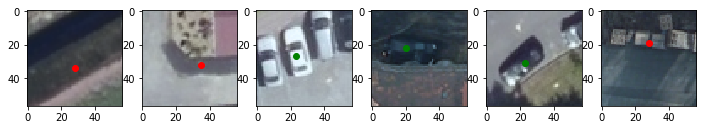

In [7]:
# Sample images from datasets
# positive examples labeled with green marks

inputs, labels = iter(dataloader).next()
coords = labels.data.numpy() * 10 + 28
plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    mark = 'go' if labels[i][2] == 1 else 'ro'
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.22 + 0.45, 0, 1))
    plt.plot(coords[i][0], coords[i][1], mark);

In [8]:
model = VGGRegCls().cuda()
criterion = RegClsLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr= 0.0001, weight_decay= 0.9)

In [9]:
results = train_model(model, criterion, optimizer, dataloader, iterations= 1000, accuracy= True)

Epoch 0, loss 0.79109561881423, accuracy 0.6983333333333334
Epoch 1, loss 0.6480809797048569, accuracy 0.7986666666666667
Epoch 2, loss 0.6055107024908066, accuracy 0.8231666666666666
Epoch 3, loss 0.5897896462976933, accuracy 0.8308333333333334
Epoch 4, loss 0.57456826582551, accuracy 0.8383333333333335
Epoch 5, loss 0.5789297276437283, accuracy 0.8368333333333333
Epoch 6, loss 0.5703527402281762, accuracy 0.8583333333333334
Epoch 7, loss 0.572328493475914, accuracy 0.8606666666666667
Epoch 8, loss 0.5826973780989647, accuracy 0.861
Epoch 9, loss 0.5901025948524475, accuracy 0.8656666666666667
Finished training!


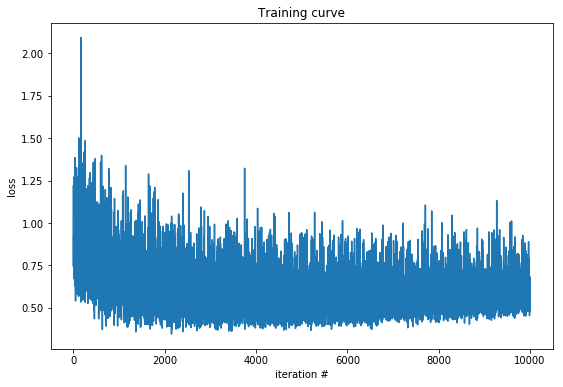

In [10]:
plt.figure(figsize= (9,6))
plt.title('Training curve'); plt.xlabel('iteration #'); plt.ylabel('loss');
plt.plot(results['train_loss_list']);

In [9]:
model.load_state_dict(torch.load('/home/kruglov/projects/siod/faster-rcnn/no-rcnn/phase_1_acc_0.865.model'))

In [10]:
model.train(False);

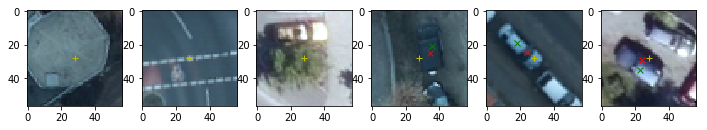

In [11]:
inputs, labels = iter(dataloader).next()
outputs_l, outputs_c = model(torch.autograd.Variable(inputs).cuda())

pred_coords = outputs_l.cpu().data.numpy() * 10 + 28
gt_coords = labels.data.numpy() * 10 + 28

plt.figure(figsize= (12,3))
for i in range(batch_size):
    plt.subplot(1, batch_size, i+1)
    if float(labels[i,2]) > 0:
        plt.plot(gt_coords[i][0], gt_coords[i][1], 'gx')
    if float(outputs_c[i][1].cpu().data) > 0.5:
        plt.plot(pred_coords[i][0], pred_coords[i][1], 'rx')
    plt.plot(28,28,'y+')
    plt.imshow(np.clip(np.transpose(inputs[i], (1,2,0)) * 0.25 + 0.46, 0, 1));

In [12]:
convnet = [[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[2,2,0],[3,1,1],[3,1,1],[3,1,1],[2,2,0],[13,2,3],[1,1,0]]
layer_names = ['conv1_1','conv1_2','pool1','conv2_1','conv2_2','pool2','conv3_1','conv3_2','conv3_3','pool2','conv4_1','conv4_2']
imsize = 213

In [13]:
layerInfos = get_receptive_fields(convnet, imsize)

In [22]:
rf_centers = torch.zeros((1,2,10,10)).cuda()

for i in range(rf_centers.shape[2]):
    for j in range(rf_centers.shape[3]):
        rf_x, rf_y = receptive_field_center(layer_names, layerInfos, j, i, 'conv4_2')
        
        rf_centers[0,0,i,j] = rf_x
        rf_centers[0,1,i,j] = rf_y

In [23]:
data_path = '/home/kruglov/projects/siod/datasets/cowc/Counting_Selwyn_LINZ/train/'

In [24]:
file_list =  pd.Series(glob.glob(os.path.join(data_path, '03*.png'))).apply(lambda x: x.split('/')[-1])

In [25]:
target_split = pd.Series(data= np.full(len(file_list), ''), index= file_list).apply(lambda x: [[0.0, 0.0]])

In [26]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(193),
    torchvision.transforms.Pad(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [27]:
dataset = OIRDSDataset(data_path, target_split.index.values, target_split.values, transform)
dataloader = torch.utils.data.DataLoader(dataset, 1, True)

In [28]:
dataiter = iter(dataloader)

torch.Size([1, 2, 10, 10])
torch.Size([1, 2, 10, 10])


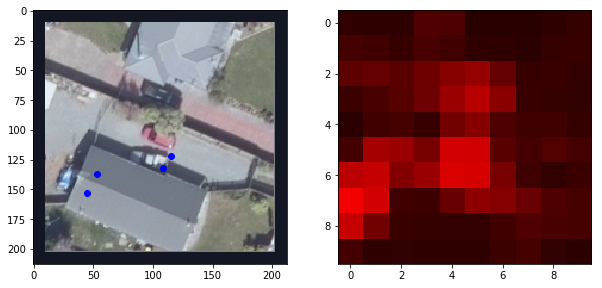

In [40]:
inputs, labels = dataiter.next()
inputs = torch.autograd.Variable(inputs).cuda()

coords, outputs_c = detect_objects(inputs, model, rf_centers, c_threshold= 0.5,
                   dist_threshold= 22, n= 4)

img = np.clip(inputs.squeeze().cpu().data.numpy().transpose(1,2,0) * 0.2 + 0.5, 0, 1)
cmap = np.full((20,20,3), 0.0)
cmap_c = outputs_c.clone()
cmap[:,:,0] = cmap_c.squeeze()[1,:].cpu().data.numpy()
plt.figure(figsize= (10,5))
plt.subplot(121)
plt.imshow(img)
if coords is not None:
    plt.plot(coords[0], coords[1], 'bo');
plt.subplot(122)
plt.imshow(cmap);